In [2]:
import rmgpy
import numpy as np
from rmgpy.molecule.molecule import *
from rmgpy.species import *
from rmgpy.chemkin import *
from rmgpy.data.rmg import RMGDatabase
from IPython.display import display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.rmg.react import react
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.data.rmg import get_db
from rmgpy.molecule.group import Group
from rmgpy.kinetics.arrhenius import ArrheniusBM
from rmgpy import settings
from arkane.input import load_input_file
import time
import matplotlib.pyplot as plt
import matplotlib
import copy
from subprocess import PIPE, run
import subprocess
%matplotlib inline

In [3]:
temps = np.linspace(500, 2000, 20)
inverse_temps = [1000/x for x in temps]
RMG_database = '/home/khalil.nor/Code/RMG-database'

def get_rate_data(r):
    rate_data = []
    for temp in temps: 
        rate_data.append(r.kinetics.get_rate_coefficient(temp, P=101325))
    return [np.log10(rate) for rate in rate_data]

def get_rate_data_log_e(r):
    rate_data = []
    for temp in temps: 
        rate_data.append(r.kinetics.get_rate_coefficient(temp, P=101325))
    return [np.log(rate) for rate in rate_data]


    
def get_template_rxn_map_and_database(family): 
    thermolibs = [
    'C1_C2_Fluorine', #putting Siddha's as most trusted because Caroline used this thermo for calcs
    'PFCA_thermo',
    'Fluorine',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'halogens',
    'CHOF_G4',
    'CHOCl_G4',
    'CHOBr_G4',
    'CHOFCl_G4',
    'CHOFBr_G4',
    'CHOFClBr_G4',
    'DFT_QCI_thermo',
    '2-BTP_G4',
    'thermo_DFT_CCSDTF12_BAC',
    'SulfurHaynes'
    ]

    families = ['R_Addition_MultipleBond']
    database_outdated = RMGDatabase()
    database_outdated.load(
        path = settings['database.directory'],
        thermo_libraries = thermolibs,  # Can add others if necessary
        kinetics_families = families,
        reaction_libraries = [],
        kinetics_depositories = ['training'],
    )

    templateRxnMap = database_outdated.kinetics.families[family].get_reaction_matches(thermo_database=database_outdated.thermo,remove_degeneracy=True,get_reverse=True,exact_matches_only=False,fix_labels=True)

    return templateRxnMap, database_outdated

def get_node_for_rate(database, rxn, templateRxnMap, family_name):
    
    node_for_rate = re.search('Estimated from node (\S+) in family R_Addition_MultipleBond.', rxn.kinetics.comment).group(1)
    group_adjacency_list = database.kinetics.families[family_name].groups.entries[node_for_rate].item.to_adjacency_list()
    print(f'Node has {len(templateRxnMap[node_for_rate])} rxns')
    
    merged_atom_labeling = {}
    for tr in templateRxnMap[node_for_rate]: 
        for ind, reactant in enumerate(tr.reactants): 
                if ind==0:
                    merged = reactant.molecule[0]
                else:
                    merged = merged.merge(reactant.molecule[0])  
        for atm in merged.atoms: 
            if '*' in atm.label:
                if atm.label not in merged_atom_labeling.keys():
                    merged_atom_labeling[atm.label] = [atm.atomtype]
                else: 
                    merged_atom_labeling[atm.label].extend([atm.atomtype])
    merged_labeling = {k: set(v) for k,v in merged_atom_labeling.items()}
    print(merged_labeling)
    
    return node_for_rate, group_adjacency_list
    

def get_atom_labeling_from_rxn(rxn):
    for ind, reactant in enumerate(rxn.reactants): 
        if ind==0:
            merged = reactant.molecule[0]
        else:
            merged = merged.merge(reactant.molecule[0])
    return merged.to_adjacency_list()

# Reactions to Test

In [3]:
templateRxnMap, database = get_template_rxn_map_and_database('R_Addition_MultipleBond')

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.883,155.55,173.376,188.387,210.872,224.909,241.381],'J/(mol*K)'), H298=(-1313.31,'kJ/mol'), S298=(422.435,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(241.12,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(O2s-(Cds-O2d)H) + group(CsCFHO) + longDistanceInteraction_noncyclic(Cs(F)-CO) + group(CsFFFO) + group(Cds-OdCsOs) + radical(CsCOF1sO2s)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.883,155.55,173.376,188.387,210.872,224.909,241.381],'J/(mol*K)'), H298=(-1313.31,'kJ/mol'), S298=(422.435,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(241.12,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(O2s-(Cds-O2d)H) + group(CsCFHO) + longDistanceInteraction_noncyclic(Cs(F)-CO) + group(CsFFFO) + group(Cds-OdCsOs) + r

In [6]:
O2_molecule = Molecule().from_adjacency_list("""multiplicity 3
1 O u1 p2 c0 {2,S}
2 O u1 p2 c0 {1,S}""")

C7F14_molecule = Molecule().from_adjacency_list("""1  F u0 p3 c0 {17,S}
2  F u0 p3 c0 {17,S}
3  F u0 p3 c0 {15,S}
4  F u0 p3 c0 {15,S}
5  F u0 p3 c0 {16,S}
6  F u0 p3 c0 {16,S}
7  F u0 p3 c0 {18,S}
8  F u0 p3 c0 {18,S}
9  F u0 p3 c0 {19,S}
10 F u0 p3 c0 {19,S}
11 F u0 p3 c0 {19,S}
12 F u0 p3 c0 {20,S}
13 F u0 p3 c0 {21,S}
14 F u0 p3 c0 {21,S}
15 C u0 p0 c0 {3,S} {4,S} {16,S} {17,S}
16 C u0 p0 c0 {5,S} {6,S} {15,S} {18,S}
17 C u0 p0 c0 {1,S} {2,S} {15,S} {19,S}
18 C u0 p0 c0 {7,S} {8,S} {16,S} {20,S}
19 C u0 p0 c0 {9,S} {10,S} {11,S} {17,S}
20 C u0 p0 c0 {12,S} {18,S} {21,D}
21 C u0 p0 c0 {13,S} {14,S} {20,D}""")

C7F14O2_411_molecule = Molecule().from_adjacency_list("""multiplicity 3
1  F u0 p3 c0 {20,S}
2  F u0 p3 c0 {20,S}
3  F u0 p3 c0 {17,S}
4  F u0 p3 c0 {17,S}
5  F u0 p3 c0 {18,S}
6  F u0 p3 c0 {18,S}
7  F u0 p3 c0 {19,S}
8  F u0 p3 c0 {19,S}
9  F u0 p3 c0 {21,S}
10 F u0 p3 c0 {22,S}
11 F u0 p3 c0 {22,S}
12 F u0 p3 c0 {22,S}
13 F u0 p3 c0 {23,S}
14 F u0 p3 c0 {23,S}
15 O u0 p2 c0 {16,S} {21,S}
16 O u1 p2 c0 {15,S}
17 C u0 p0 c0 {3,S} {4,S} {18,S} {20,S}
18 C u0 p0 c0 {5,S} {6,S} {17,S} {19,S}
19 C u0 p0 c0 {7,S} {8,S} {18,S} {21,S}
20 C u0 p0 c0 {1,S} {2,S} {17,S} {22,S}
21 C u0 p0 c0 {9,S} {15,S} {19,S} {23,S}
22 C u0 p0 c0 {10,S} {11,S} {12,S} {20,S}
23 C u1 p0 c0 {13,S} {14,S} {21,S}""")





C7F14O2_412_molecule = Molecule().from_adjacency_list("""multiplicity 3
1  F u0 p3 c0 {19,S}
2  F u0 p3 c0 {19,S}
3  F u0 p3 c0 {17,S}
4  F u0 p3 c0 {17,S}
5  F u0 p3 c0 {18,S}
6  F u0 p3 c0 {18,S}
7  F u0 p3 c0 {20,S}
8  F u0 p3 c0 {20,S}
9  F u0 p3 c0 {21,S}
10 F u0 p3 c0 {21,S}
11 F u0 p3 c0 {21,S}
12 F u0 p3 c0 {22,S}
13 F u0 p3 c0 {22,S}
14 F u0 p3 c0 {23,S}
15 O u0 p2 c0 {16,S} {22,S}
16 O u1 p2 c0 {15,S}
17 C u0 p0 c0 {3,S} {4,S} {18,S} {19,S}
18 C u0 p0 c0 {5,S} {6,S} {17,S} {20,S}
19 C u0 p0 c0 {1,S} {2,S} {17,S} {21,S}
20 C u0 p0 c0 {7,S} {8,S} {18,S} {23,S}
21 C u0 p0 c0 {9,S} {10,S} {11,S} {19,S}
22 C u0 p0 c0 {12,S} {13,S} {15,S} {23,S}
23 C u1 p0 c0 {14,S} {20,S} {22,S}""")



reactants_ = [Species(molecule=[C7F14_molecule]), Species(molecule=[O2_molecule])]
products_ = [Species(molecule=[C7F14O2_411_molecule])]
                     
                     

C7F14_O2_411 = Reaction(reactants=reactants_, products=products_)


database.kinetics.families['R_Addition_MultipleBond'].add_atom_labels_for_reaction(C7F14_O2_411)
template_labels = database.kinetics.families['R_Addition_MultipleBond'].get_reaction_template_labels(C7F14_O2_411)
template = database.kinetics.families['R_Addition_MultipleBond'].retrieve_template(template_labels)
node = template[0].label

C7F14_O2_411_atomlabeling = get_atom_labeling_from_rxn(C7F14_O2_411)


reactants_ = [Species(molecule=[C7F14_molecule]), Species(molecule=[O2_molecule])]
products_ = [Species(molecule=[C7F14O2_412_molecule])]
C7F14_O2_412 = Reaction(reactants=reactants_, products=products_)
   
database.kinetics.families['R_Addition_MultipleBond'].add_atom_labels_for_reaction(C7F14_O2_412)
template_labels = database.kinetics.families['R_Addition_MultipleBond'].get_reaction_template_labels(C7F14_O2_412)
template = database.kinetics.families['R_Addition_MultipleBond'].retrieve_template(template_labels)
node = template[0].label

C7F14_O2_412_atomlabeling = get_atom_labeling_from_rxn(C7F14_O2_412)



In [ ]:
O2_molecule

perfluoroheptene_molecule  = Molecule().from_adjacency_list("""1  F u0 p3 c0 {17,S}
2  F u0 p3 c0 {17,S}
3  F u0 p3 c0 {15,S}
4  F u0 p3 c0 {15,S}
5  F u0 p3 c0 {16,S}
6  F u0 p3 c0 {16,S}
7  F u0 p3 c0 {18,S}
8  F u0 p3 c0 {18,S}
9  F u0 p3 c0 {19,S}
10 F u0 p3 c0 {19,S}
11 F u0 p3 c0 {19,S}
12 F u0 p3 c0 {20,S}
13 F u0 p3 c0 {21,S}
14 F u0 p3 c0 {21,S}
15 C u0 p0 c0 {3,S} {4,S} {16,S} {17,S}
16 C u0 p0 c0 {5,S} {6,S} {15,S} {18,S}
17 C u0 p0 c0 {1,S} {2,S} {15,S} {19,S}
18 C u0 p0 c0 {7,S} {8,S} {16,S} {20,S}
19 C u0 p0 c0 {9,S} {10,S} {11,S} {17,S}
20 C u0 p0 c0 {12,S} {18,S} {21,D}
21 C u0 p0 c0 {13,S} {14,S} {20,D}""")

multiplicity -187
1     F u0 p3 c0 {17,S}
2     F u0 p3 c0 {17,S}
3     F u0 p3 c0 {15,S}
4     F u0 p3 c0 {15,S}
5     F u0 p3 c0 {16,S}
6     F u0 p3 c0 {16,S}
7     F u0 p3 c0 {18,S}
8     F u0 p3 c0 {18,S}
9     F u0 p3 c0 {19,S}
10    F u0 p3 c0 {19,S}
11    F u0 p3 c0 {19,S}
12    F u0 p3 c0 {20,S}
13    F u0 p3 c0 {21,S}
14    F u0 p3 c0 {21,S}
15    C u0 p0 c0 {3,S} {4,S} {16,S} {17,S}
16    C u0 p0 c0 {5,S} {6,S} {15,S} {18,S}
17    C u0 p0 c0 {1,S} {2,S} {15,S} {19,S}
18    C u0 p0 c0 {7,S} {8,S} {16,S} {20,S}
19    C u0 p0 c0 {9,S} {10,S} {11,S} {17,S}
20 *1 C u0 p0 c0 {12,S} {18,S} {21,D}
21 *2 C u0 p0 c0 {13,S} {14,S} {20,D}
22 *3 O u1 p2 c0 {23,S}
23    O u1 p2 c0 {22,S}

Root_N-3R-inRing_N-3R->C_N-1R!H->N_2R!H->C_3BrClFLiNOS->O_Ext-2C-R
1 *2 C   u0         {2,[D,T,B]} {3,[S,B,D,T,Q]}
2 *1 C   u0         {1,[D,T,B]}
3    R!H ux         {1,[S,B,D,T,Q]}
4 *3 O   u[1,2,3,4] r0



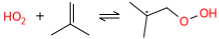

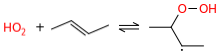

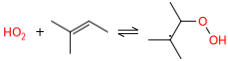

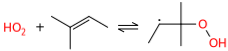

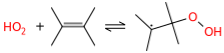

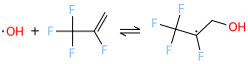

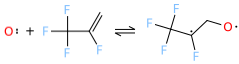

multiplicity -187
1     F u0 p3 c0 {17,S}
2     F u0 p3 c0 {17,S}
3     F u0 p3 c0 {15,S}
4     F u0 p3 c0 {15,S}
5     F u0 p3 c0 {16,S}
6     F u0 p3 c0 {16,S}
7     F u0 p3 c0 {18,S}
8     F u0 p3 c0 {18,S}
9     F u0 p3 c0 {19,S}
10    F u0 p3 c0 {19,S}
11    F u0 p3 c0 {19,S}
12    F u0 p3 c0 {20,S}
13    F u0 p3 c0 {21,S}
14    F u0 p3 c0 {21,S}
15    C u0 p0 c0 {3,S} {4,S} {16,S} {17,S}
16    C u0 p0 c0 {5,S} {6,S} {15,S} {18,S}
17    C u0 p0 c0 {1,S} {2,S} {15,S} {19,S}
18    C u0 p0 c0 {7,S} {8,S} {16,S} {20,S}
19    C u0 p0 c0 {9,S} {10,S} {11,S} {17,S}
20 *2 C u0 p0 c0 {12,S} {18,S} {21,D}
21 *1 C u0 p0 c0 {13,S} {14,S} {20,D}
22 *3 O u1 p2 c0 {23,S}
23    O u1 p2 c0 {22,S}

Root_N-3R-inRing_N-3R->C_N-1R!H->N_2R!H->C_3BrClFLiNOS->O_Ext-2C-R_3O-u1_Sp-2C=1COS_Sp-4R!H-2C_Ext-2C-R
1 *2 C   u0 {2,D} {3,S} {4,S}
2 *1 C   u0 {1,D}
3    C   u0 {1,S}
4    R!H u0 {1,S}
5 *3 O   u1 r0



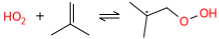

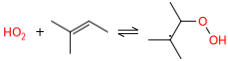

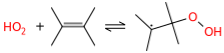

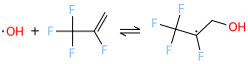

In [7]:
nodes_to_watch_for = ['Root_N-3R-inRing_N-3R->C_N-1R!H->N_2R!H->C_3BrClFLiNOS->O_Ext-2C-R', #O2(2)+C7F14(308)<=>C7F14O2(411)                     6.600280e+21 -2.483    26.139  
                      'Root_N-3R-inRing_N-3R->C_N-1R!H->N_2R!H->C_3BrClFLiNOS->O_Ext-2C-R_3O-u1_Sp-2C=1COS_Sp-4R!H-2C_Ext-2C-R'] #O2(2)+C7F14(308)<=>C7F14O2(412)                     2.542760e+12 0.119     17.556
atom_labeling = [C7F14_O2_411_atomlabeling, C7F14_O2_412_atomlabeling]
for atom_labeling, node_label in zip(atom_labeling, nodes_to_watch_for):
    print(atom_labeling)
    print(node_label)      
    group = database.kinetics.families['R_Addition_MultipleBond'].groups.entries[node_label].item   
    print(group.to_adjacency_list())
    training_rxns = templateRxnMap[node_label]
    for rxn in training_rxns:
        display(rxn)

In [4]:
from rmgpy.reaction import Reaction
from rmgpy.kinetics import Arrhenius
from rmgpy.molecule import Molecule
from rmgpy.species import Species

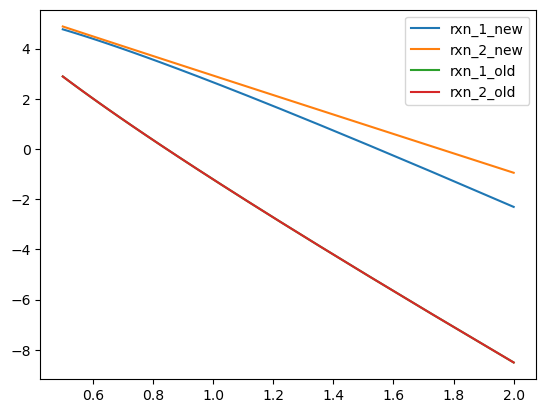

In [16]:
params = {'A': 6.60028e+21, 'b': -2.483, 'Ea': 26.139}
rxn_1_new = Reaction(kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))    #O2(2) + C7F14(308) <=> C7F14O2(411) 
        
params = {'A': 2.54276e+12, 'b': 0.119, 'Ea': 17.556}  
rxn_2_new = Reaction(kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))    #O2(2) + C7F14(308) <=> C7F14O2(412) 
    
    
params = {'A': 1.674057e+02, 'b': 2.988, 'Ea': 29.267}
rxn_1_old = Reaction(kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))    #O2(2) + C7F14(308) <=> C7F14O2(411) 
params = {'A': 1.674057e+02, 'b': 2.988,'Ea': 29.267}
rxn_2_old = Reaction(kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))    #O2(2) + C7F14(308) <=> C7F14O2(412) 


fig = plt.figure()
ax1 = fig.add_subplot(111)
for rxn, label in zip([rxn_1_new, rxn_2_new, rxn_1_old, rxn_2_old], ['rxn_1_new', 'rxn_2_new', 'rxn_1_old', 'rxn_2_old']): 
    ax1.plot(inverse_temps, get_rate_data(rxn), label=label)
plt.legend()

In [53]:
HF_molecule = Molecule().from_adjacency_list("""1 F u0 p3 c0 {2,S}
2 H u0 p0 c0 {1,S}""")

PFOA_molecule = Molecule().from_adjacency_list("""1  F u0 p3 c0 {22,S}
2  F u0 p3 c0 {22,S}
3  F u0 p3 c0 {20,S}
4  F u0 p3 c0 {20,S}
5  F u0 p3 c0 {19,S}
6  F u0 p3 c0 {19,S}
7  F u0 p3 c0 {18,S}
8  F u0 p3 c0 {18,S}
9  F u0 p3 c0 {21,S}
10 F u0 p3 c0 {21,S}
11 F u0 p3 c0 {23,S}
12 F u0 p3 c0 {23,S}
13 F u0 p3 c0 {24,S}
14 F u0 p3 c0 {24,S}
15 F u0 p3 c0 {24,S}
16 O u0 p2 c0 {25,S} {26,S}
17 O u0 p2 c0 {25,D}
18 C u0 p0 c0 {7,S} {8,S} {19,S} {21,S}
19 C u0 p0 c0 {5,S} {6,S} {18,S} {20,S}
20 C u0 p0 c0 {3,S} {4,S} {19,S} {22,S}
21 C u0 p0 c0 {9,S} {10,S} {18,S} {23,S}
22 C u0 p0 c0 {1,S} {2,S} {20,S} {24,S}
23 C u0 p0 c0 {11,S} {12,S} {21,S} {25,S}
24 C u0 p0 c0 {13,S} {14,S} {15,S} {22,S}
25 C u0 p0 c0 {16,S} {17,D} {23,S}
26 H u0 p0 c0 {16,S}""")

perfluoroheptene_molecule  = Molecule().from_adjacency_list("""1  F u0 p3 c0 {17,S}
2  F u0 p3 c0 {17,S}
3  F u0 p3 c0 {15,S}
4  F u0 p3 c0 {15,S}
5  F u0 p3 c0 {16,S}
6  F u0 p3 c0 {16,S}
7  F u0 p3 c0 {18,S}
8  F u0 p3 c0 {18,S}
9  F u0 p3 c0 {19,S}
10 F u0 p3 c0 {19,S}
11 F u0 p3 c0 {19,S}
12 F u0 p3 c0 {20,S}
13 F u0 p3 c0 {21,S}
14 F u0 p3 c0 {21,S}
15 C u0 p0 c0 {3,S} {4,S} {16,S} {17,S}
16 C u0 p0 c0 {5,S} {6,S} {15,S} {18,S}
17 C u0 p0 c0 {1,S} {2,S} {15,S} {19,S}
18 C u0 p0 c0 {7,S} {8,S} {16,S} {20,S}
19 C u0 p0 c0 {9,S} {10,S} {11,S} {17,S}
20 C u0 p0 c0 {12,S} {18,S} {21,D}
21 C u0 p0 c0 {13,S} {14,S} {20,D}""")

reactants_ = [Species(molecule=[PFOA_molecule])]
products_ = [Species(molecule=[CO2_mol]), Species(molecule=[HF_molecule]), Species(molecule=[perfluoroheptene_molecule])]
                     
                     


PFOA_to_CO2_HF_C7F14 = Reaction(reactants=reactants_, products=products_)


database.kinetics.families['XY_elimination_hydroxyl'].add_atom_labels_for_reaction(PFOA_to_CO2_HF_C7F14)
template_labels = database.kinetics.families['XY_elimination_hydroxyl'].get_reaction_template_labels(PFOA_to_CO2_HF_C7F14)
template = database.kinetics.families['XY_elimination_hydroxyl'].retrieve_template(template_labels)
node = template[0].label

print(get_atom_labeling_from_rxn(PFOA_to_CO2_HF_C7F14))

#PFOA atom labeling for 'XY_elimination_hydroxyl'

1     F u0 p3 c0 {22,S}
2     F u0 p3 c0 {22,S}
3     F u0 p3 c0 {20,S}
4     F u0 p3 c0 {20,S}
5     F u0 p3 c0 {19,S}
6     F u0 p3 c0 {19,S}
7     F u0 p3 c0 {18,S}
8     F u0 p3 c0 {18,S}
9  *1 F u0 p3 c0 {21,S}
10    F u0 p3 c0 {21,S}
11    F u0 p3 c0 {23,S}
12    F u0 p3 c0 {23,S}
13    F u0 p3 c0 {24,S}
14    F u0 p3 c0 {24,S}
15    F u0 p3 c0 {24,S}
16 *5 O u0 p2 c0 {25,S} {26,S}
17    O u0 p2 c0 {25,D}
18    C u0 p0 c0 {7,S} {8,S} {19,S} {21,S}
19    C u0 p0 c0 {5,S} {6,S} {18,S} {20,S}
20    C u0 p0 c0 {3,S} {4,S} {19,S} {22,S}
21 *2 C u0 p0 c0 {9,S} {10,S} {18,S} {23,S}
22    C u0 p0 c0 {1,S} {2,S} {20,S} {24,S}
23 *3 C u0 p0 c0 {11,S} {12,S} {21,S} {25,S}
24    C u0 p0 c0 {13,S} {14,S} {15,S} {22,S}
25 *4 C u0 p0 c0 {16,S} {17,D} {23,S}
26 *6 H u0 p0 c0 {16,S}



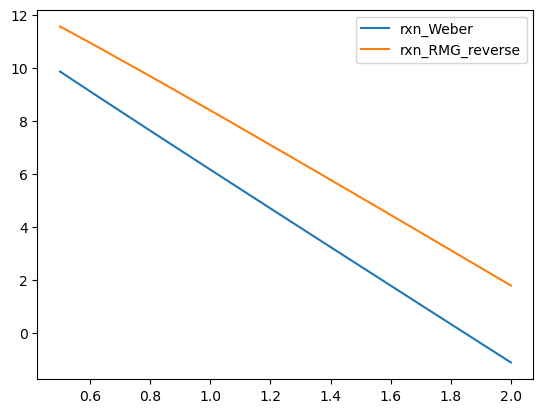

In [43]:
#PFlac <=> C7F14 + CO2 (Weber says C7F14 is perfluorohept-1-ene in text, but input file comments that is a carbene. Caroline gave me training data that says this C7F14 is a carbene (in 1+2_Cycladdition)

#Weber rate 
# Reaction 4
# reaction('PFlac => C7F14 + CO2', [1.047000e+12, 0.427, 32670.0]) #units(length='cm', time='s', quantity='mol', act_energy='cal/mol')
# Lactone to CO2 + C7F14carbene
params = {'A': 1.047000e+12, 'b': 0.427, 'Ea': 32670.0}
rxn_Weber = Reaction(kinetics = Arrhenius(A=(params['A'], 's^-1'), n=params['b'], Ea=(params['Ea'], 'cal/mol')))   
    
#in edge
# ! Reaction index: Chemkin #2997; RMG #2045
# ! Template reaction: 1+2_Cycloaddition
# ! Flux pairs: CO2(6), C8F14O2(271); C7F14(345), C8F14O2(271); 
# ! From training reaction 25 used for Root_N-1R->C_Ext-3R-R_Ext-3R-R_N-4R!H->O_4CF->C_Ext-4C-R_6R!H->C_Ext-6C-R_7R!H->C
# ! Exact match found for rate rule [Root_N-1R->C_Ext-3R-R_Ext-3R-R_N-4R!H->O_4CF->C_Ext-4C-R_6R!H->C_Ext-6C-R_7R!H->C]
# ! Euclidian distance = 0
# ! Multiplied by reaction path degeneracy 2.0
# ! family: 1+2_Cycloaddition
# CO2(6)+C7F14(345)<=>C8F14O2(271)                    8.056443e+03 2.352     13.280  
#units(length='cm', time='s', quantity='mol', act_energy='kcal/mol')

PFLactone_mol = Molecule().from_adjacency_list("""1  F u0 p3 c0 {22,S}
2  F u0 p3 c0 {22,S}
3  F u0 p3 c0 {19,S}
4  F u0 p3 c0 {19,S}
5  F u0 p3 c0 {18,S}
6  F u0 p3 c0 {18,S}
7  F u0 p3 c0 {17,S}
8  F u0 p3 c0 {17,S}
9  F u0 p3 c0 {20,S}
10 F u0 p3 c0 {20,S}
11 F u0 p3 c0 {21,S}
12 F u0 p3 c0 {23,S}
13 F u0 p3 c0 {23,S}
14 F u0 p3 c0 {23,S}
15 O u0 p2 c0 {21,S} {24,S}
16 O u0 p2 c0 {24,D}
17 C u0 p0 c0 {7,S} {8,S} {18,S} {20,S}
18 C u0 p0 c0 {5,S} {6,S} {17,S} {19,S}
19 C u0 p0 c0 {3,S} {4,S} {18,S} {22,S}
20 C u0 p0 c0 {9,S} {10,S} {17,S} {21,S}
21 C u0 p0 c0 {11,S} {15,S} {20,S} {24,S}
22 C u0 p0 c0 {1,S} {2,S} {19,S} {23,S}
23 C u0 p0 c0 {12,S} {13,S} {14,S} {22,S}
24 C u0 p0 c0 {15,S} {16,D} {21,S}""")

CO2_mol = Molecule().from_adjacency_list("""1 O u0 p2 c0 {3,D}
2 O u0 p2 c0 {3,D}
3 C u0 p0 c0 {1,D} {2,D}""")


C7F14_mol = Molecule().from_adjacency_list("""1  F u0 p3 c0 {18,S}
2  F u0 p3 c0 {18,S}
3  F u0 p3 c0 {15,S}
4  F u0 p3 c0 {15,S}
5  F u0 p3 c0 {16,S}
6  F u0 p3 c0 {16,S}
7  F u0 p3 c0 {17,S}
8  F u0 p3 c0 {17,S}
9  F u0 p3 c0 {19,S}
10 F u0 p3 c0 {19,S}
11 F u0 p3 c0 {20,S}
12 F u0 p3 c0 {20,S}
13 F u0 p3 c0 {20,S}
14 F u0 p3 c0 {21,S}
15 C u0 p0 c0 {3,S} {4,S} {16,S} {18,S}
16 C u0 p0 c0 {5,S} {6,S} {15,S} {17,S}
17 C u0 p0 c0 {7,S} {8,S} {16,S} {19,S}
18 C u0 p0 c0 {1,S} {2,S} {15,S} {20,S}
19 C u0 p0 c0 {9,S} {10,S} {17,S} {21,S}
20 C u0 p0 c0 {11,S} {12,S} {13,S} {18,S}
21 C u0 p1 c0 {14,S} {19,S}""")

reactants_ = [Species(molecule=[CO2_mol]), Species(molecule=[C7F14_mol])]
products_ = [Species(molecule=[PFLactone_mol])]

for spec in reactants_+products_:
    spec.thermo = database.thermo.get_thermo_data(spec)
    
    
params = {'A': 8.056443e+03, 'b': 2.352, 'Ea': 13.280}
rxn_RMG = Reaction(reactants=reactants_, products=products_, kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))    
reverse_kinetics = rxn_RMG.generate_reverse_rate_coefficient()
rxn_RMG_reverse = Reaction()
rxn_RMG_reverse.kinetics = reverse_kinetics
      
fig = plt.figure()
ax1 = fig.add_subplot(111)
for rxn, label in zip([rxn_Weber, rxn_RMG_reverse], ['rxn_Weber', 'rxn_RMG_reverse']): 
    ax1.plot(inverse_temps, get_rate_data(rxn), label=label)
plt.legend()


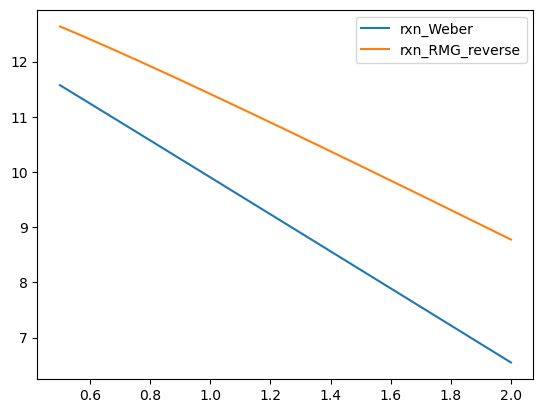

In [44]:
#rate from Weber
# Reaction 3
# reaction('PFlac => PFHpO + CO', [2.690000e+13, -0.052, 15420.0])
# Lactone to CO + C7F14O
params = {'A': 2.690000e+13, 'b': -0.052, 'Ea': 15420.0}
rxn_Weber = Reaction(kinetics = Arrhenius(A=(params['A'], 's^-1'), n=params['b'], Ea=(params['Ea'], 'cal/mol')))   
    

#in core, but in reverse direction
# Reaction 329
#reaction('CO(8) + C7F14O(413) <=> C8F14O2(271)', [6.587730e+01, 2.613, 43.645])
    
CO_mol = Molecule().from_adjacency_list("""1 O u0 p1 c+1 {2,T}
2 C u0 p1 c-1 {1,T}""")

PFHpO_mol = Molecule().from_adjacency_list("""1  F u0 p3 c0 {19,S}
2  F u0 p3 c0 {19,S}
3  F u0 p3 c0 {17,S}
4  F u0 p3 c0 {17,S}
5  F u0 p3 c0 {16,S}
6  F u0 p3 c0 {16,S}
7  F u0 p3 c0 {18,S}
8  F u0 p3 c0 {18,S}
9  F u0 p3 c0 {20,S}
10 F u0 p3 c0 {20,S}
11 F u0 p3 c0 {21,S}
12 F u0 p3 c0 {21,S}
13 F u0 p3 c0 {21,S}
14 F u0 p3 c0 {22,S}
15 O u0 p2 c0 {22,D}
16 C u0 p0 c0 {5,S} {6,S} {17,S} {18,S}
17 C u0 p0 c0 {3,S} {4,S} {16,S} {19,S}
18 C u0 p0 c0 {7,S} {8,S} {16,S} {20,S}
19 C u0 p0 c0 {1,S} {2,S} {17,S} {21,S}
20 C u0 p0 c0 {9,S} {10,S} {18,S} {22,S}
21 C u0 p0 c0 {11,S} {12,S} {13,S} {19,S}
22 C u0 p0 c0 {14,S} {15,D} {20,S}""") #C7F14O(413)

reactants_ = [Species(molecule=[CO_mol]), Species(molecule=[PFHpO_mol])]
products_ = [Species(molecule=[PFLactone_mol])]

for spec in reactants_+products_:
    spec.thermo = database.thermo.get_thermo_data(spec)
    
    
params = {'A': 6.587730e+01, 'b': 2.613, 'Ea': 43.645}
rxn_RMG = Reaction(reactants=reactants_, products=products_, kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))    
reverse_kinetics = rxn_RMG.generate_reverse_rate_coefficient()
rxn_RMG_reverse = Reaction()
rxn_RMG_reverse.kinetics = reverse_kinetics    

fig = plt.figure()
ax1 = fig.add_subplot(111)
for rxn, label in zip([rxn_Weber, rxn_RMG_reverse], ['rxn_Weber', 'rxn_RMG_reverse']): 
    ax1.plot(inverse_temps, get_rate_data(rxn), label=label)
plt.legend()

In [50]:
thermolibs = [
    'C1_C2_Fluorine', #putting Siddha's as most trusted because Caroline used this thermo for calcs
    'PFCA_thermo',
    'Fluorine',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'halogens',
    'CHOF_G4',
    'CHOCl_G4',
    'CHOBr_G4',
    'CHOFCl_G4',
    'CHOFBr_G4',
    'CHOFClBr_G4',
    'DFT_QCI_thermo',
    '2-BTP_G4',
    'thermo_DFT_CCSDTF12_BAC',
    'SulfurHaynes'
    ]

families = ['R_Addition_MultipleBond', 'XY_elimination_hydroxyl']
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = thermolibs,  # Can add others if necessary
    kinetics_families = families,
    reaction_libraries = [],
    kinetics_depositories = ['training'],
)


In [1]:
from rmgpy.reaction import Reaction
from rmgpy.kinetics import Arrhenius
from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.chemkin import load_chemkin_file

In [5]:
#PFlactone -> C7F14 + CO2

#path definitions to mechanisms for testing 
full_path = '/projects/westgroup/nora/Code/'
mech_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group/chemkin/copies/copy_chem_edge_annotated.inp'
dictionary_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group/chemkin/species_edge_dictionary.txt'
rmg_species, rmg_reactions = load_chemkin_file(mech_path, dictionary_path=dictionary_path) 

In [10]:
#RMG

# ! Reaction index: Chemkin #3865; RMG #1845
# ! Template reaction: 1+2_Cycloaddition
# ! Flux pairs: CO2(6), C8F14O2(271); C7F14(324), C8F14O2(271); 
# ! From training reaction 25 used for Root_N-1R->C_Ext-3R-R_Ext-3R-R_N-4R!H->O_4CF->C_Ext-4C-R_6R!H->C_Ext-6C-R_7R!H->C
# ! Exact match found for rate rule [Root_N-1R->C_Ext-3R-R_Ext-3R-R_N-4R!H->O_4CF->C_Ext-4C-R_6R!H->C_Ext-6C-R_7R!H->C]
# ! Euclidian distance = 0
# ! Multiplied by reaction path degeneracy 2.0
# ! family: 1+2_Cycloaddition
# CO2(6)+C7F14(324)<=>C8F14O2(271)                    8.056443e+03 2.352     13.280 

rmg_species, rmg_reactions = load_chemkin_file(mech_path, dictionary_path=dictionary_path) 
species_of_interest = ['(6)', '(324)', '(271)']
for rxn in rmg_reactions: 
    if all([spec in str(rxn) for spec in species_of_interest]): 
        print(rxn)
    
# params = {'A': 1.674057e+02, 'b': 2.988, 'Ea': 29.267}
# rxn_1_old = Reaction(kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))    #O2(2) + C7F14(308) <=> C7F14O2(411) 


# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# for rxn, label in zip([rxn_1_new,rxn_1_old], ['rxn_1_new', 'rxn_1_old']): 
#     ax1.plot(inverse_temps, get_rate_data(rxn), label=label)
# plt.legend()

CO2(6) + F[C]C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(324) <=> O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(271)


In [12]:
species_of_interest = ['(6)', '(324)', '(271)']
for rxn in rmg_reactions: 
    if all([spec in str(rxn) for spec in species_of_interest]): 
        rxn_1_rmg = rxn

In [22]:
print(rxn_1_rmg.kinetics)
reverse_kinetics = rxn_1_rmg.generate_reverse_rate_coefficient()
rxn_RMG_reverse = Reaction(reactants=rxn_1_rmg.products, products = rxn_1_rmg.reactants)
rxn_RMG_reverse.kinetics = reverse_kinetics

Arrhenius(A=(8056.44,'cm^3/(mol*s)'), n=2.352, Ea=(13.28,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 25 used for Root_N-1R->C_Ext-3R-R_Ext-3R-R_N-4R!H->O_4CF->C_Ext-4C-R_6R!H->C_Ext-6C-R_7R!H->C
Exact match found for rate rule [Root_N-1R->C_Ext-3R-R_Ext-3R-R_N-4R!H->O_4CF->C_Ext-4C-R_6R!H->C_Ext-6C-R_7R!H->C]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: 1+2_Cycloaddition""")


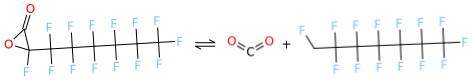

In [24]:
rxn_RMG_reverse

In [23]:
print(rxn_RMG_reverse.kinetics)

Arrhenius(A=(4.53703e+17,'s^-1'), n=-0.786528, Ea=(131.45,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.11898, dn = +|- 0.014883, dEa = +|- 0.0778051 kJ/mol""")


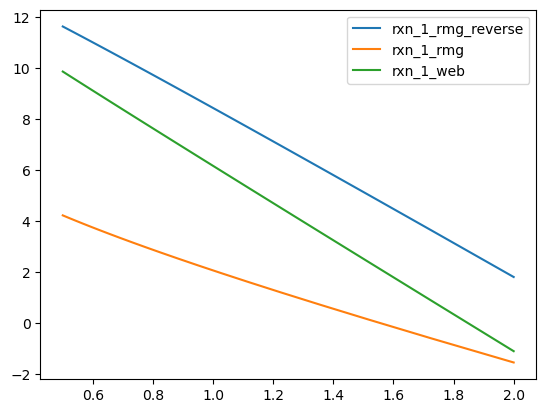

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

temps = np.linspace(500, 2000, 20)
inverse_temps = [1000/x for x in temps]

web_params = [1.047000e+12, 0.427, 32670.0]
#units(length='cm', time='s', quantity='mol', act_energy='cal/mol') from weber cti
params = {'A': web_params[0], 'b': web_params[1], 'Ea': web_params[2]}
rxn_1_web = Reaction(kinetics = Arrhenius(A=(params['A'], 's^-1'), n=params['b'], Ea=(params['Ea'], 'cal/mol')))   


for rxn, label in zip([rxn_RMG_reverse, rxn_1_rmg, rxn_1_web], ['rxn_1_rmg_reverse', 'rxn_1_rmg', 'rxn_1_web']): 
    ax1.plot(inverse_temps, get_rate_data(rxn), label=label)
plt.legend()

In [ ]:
#forbidding PFlac = biradical

[O]C(=O)[C](F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(342) <=> O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(271) Birad_recombination
in reverse direction
[O]C(F)([C]=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(343) <=> O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(271) Birad_recombination
in reverse direction
O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(271) <=> O=C1OC(F)(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C1(F)F(338) 1,2_XY_interchange
in forward direction
FOC1=C(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)O1(339) <=> O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(271) 1,3_sigmatropic_rearrangement
in reverse direction
FC(=C1OO1)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(340) <=> O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(271) 1,3_sigmatropic_rearrangement
in reverse direction
FC1=C(OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)O1(341) <=> O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F(271) 1,3_sigmatropic_rearrangement
in rev

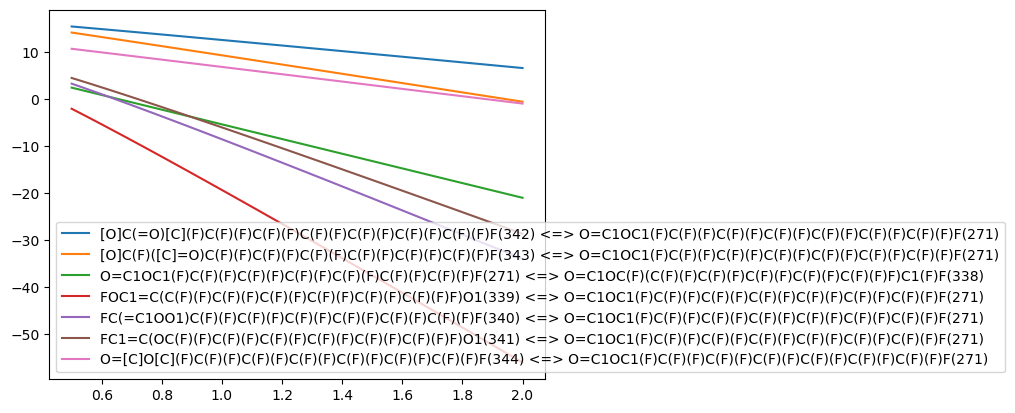

In [46]:
# how many ways does the alphalactone undergo isomerization ?

fig = plt.figure()
ax1 = fig.add_subplot(111)

birad_matchings = []

for rxn in rmg_reactions: 
    if '(271)' in str(rxn) and len(rxn.reactants+rxn.products)==2: 
        print(rxn, rxn.family)
    
        if '(271)' in str(rxn.reactants[0]):
            print('in forward direction')
            ax1.plot(inverse_temps, get_rate_data(rxn), label=str(rxn))
            
        if '(271)' in str(rxn.products[0]):
            print('in reverse direction')
            reverse_kinetics = rxn.generate_reverse_rate_coefficient()
            rxn_reverse = Reaction(reactants=rxn.products, products = rxn.reactants)
            rxn_reverse.kinetics = reverse_kinetics
            ax1.plot(inverse_temps, get_rate_data(rxn_reverse), label=str(rxn))
            
        if rxn.family=='Birad_recombination':
            birad_matchings.append(rxn)
            
plt.legend()
#we should forbid this from these families

In [ ]:
#seems like the birad r recombination family is reacting lactone to a biradical (so lactone that is left is not enough to make the proper amounts of C7F14 + CO2, so left in edge)

In [51]:
thermolibs = [
    'C1_C2_Fluorine', #putting Siddha's as most trusted because Caroline used this thermo for calcs
    'PFCA_thermo',
    'Fluorine',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'halogens',
    'CHOF_G4',
    'CHOCl_G4',
    'CHOBr_G4',
    'CHOFCl_G4',
    'CHOFBr_G4',
    'CHOFClBr_G4',
    'DFT_QCI_thermo',
    '2-BTP_G4',
    'thermo_DFT_CCSDTF12_BAC',
    'SulfurHaynes'
    ]

families = ['Birad_recombination']
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = thermolibs,  # Can add others if necessary
    kinetics_families = families,
    reaction_libraries = [],
    kinetics_depositories = ['training'],
)



for rxn in birad_matchings: 
    database.kinetics.families['Birad_recombination'].add_atom_labels_for_reaction(rxn)
    
    if '(271)' in str(rxn.reactants[0]):
        print(rxn.reactants[0].to_adjacency_list())

    if '(271)' in str(rxn.products[0]):
        print(rxn.products[0].to_adjacency_list())


O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
1     F u0 p3 c0 {22,S}
2     F u0 p3 c0 {22,S}
3     F u0 p3 c0 {18,S}
4     F u0 p3 c0 {18,S}
5     F u0 p3 c0 {17,S}
6     F u0 p3 c0 {17,S}
7     F u0 p3 c0 {19,S}
8     F u0 p3 c0 {19,S}
9     F u0 p3 c0 {20,S}
10    F u0 p3 c0 {20,S}
11    F u0 p3 c0 {21,S}
12    F u0 p3 c0 {23,S}
13    F u0 p3 c0 {23,S}
14    F u0 p3 c0 {23,S}
15 *2 O u0 p2 c0 {21,S} {24,S}
16    O u0 p2 c0 {24,D}
17    C u0 p0 c0 {5,S} {6,S} {18,S} {19,S}
18    C u0 p0 c0 {3,S} {4,S} {17,S} {22,S}
19    C u0 p0 c0 {7,S} {8,S} {17,S} {20,S}
20    C u0 p0 c0 {9,S} {10,S} {19,S} {21,S}
21 *1 C u0 p0 c0 {11,S} {15,S} {20,S} {24,S}
22    C u0 p0 c0 {1,S} {2,S} {18,S} {23,S}
23    C u0 p0 c0 {12,S} {13,S} {14,S} {22,S}
24    C u0 p0 c0 {15,S} {16,D} {21,S}

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
1     F u0 p3 c0 {22,S}
2     F u0 p3 c0 {22,S}
3     F u0 p3 c0 {19,S}
4     F u0 p3 c0 {19,S}
5     F u0 p3 c0 {18,S}
6     F u0 p3 c0 {18,S}
7     F u0 p

In [ ]:
#why doesn't my model in projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/chem_edge_annotated.inp
#include the following: 

#  Reaction index: Chemkin #1; RMG #1679
#  Template reaction: XY_elimination_hydroxyl
#  Flux pairs: PFOA(1), HF(122); PFOA(1), C7F14(222); PFOA(1), CO2(13);
#  Estimated from node Root_1R!H->C_N-5Br1sCl1sF1sH->H_5Br1sCl1sF1s->F1s_Ext-2C-R_7R!H->O in family XY_elimination_hydroxyl.
#  Multiplied by reaction path degeneracy 2.0

# Reaction 1
#reaction('PFOA(1) <=> HF(122) + CO2(13) + C7F14(222)', [5.395600e+09, 1.12, 50.791])


#which is the first reaction in main?


thermolibs = [
    'C1_C2_Fluorine', #putting Siddha's as most trusted because Caroline used this thermo for calcs
    'PFCA_thermo',
    'Fluorine',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'halogens',
    'CHOF_G4',
    'CHOCl_G4',
    'CHOBr_G4',
    'CHOFCl_G4',
    'CHOFBr_G4',
    'CHOFClBr_G4',
    'DFT_QCI_thermo',
    '2-BTP_G4',
    'thermo_DFT_CCSDTF12_BAC',
    'SulfurHaynes'
    ]

families = ['Birad_recombination']
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = thermolibs,  # Can add others if necessary
    kinetics_families = families,
    reaction_libraries = [],
    kinetics_depositories = ['training'],
)

In [3]:
#HF + OH = F + H2O 

#path definitions to mechanisms for testing 
full_path = '/projects/westgroup/nora/Code/'
mech_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/copies/copy_chem_annotated.inp'
dictionary_path = full_path+'projects/rebasing_PFAS/models/PFAS/insights_from_Weber/PFOA+Air/fix_reg_spec_in_core/lower_tolerance/forbidden_group_birad_recomb/chemkin/species_edge_dictionary.txt'
rmg_species, rmg_reactions = load_chemkin_file(mech_path, dictionary_path=dictionary_path) 

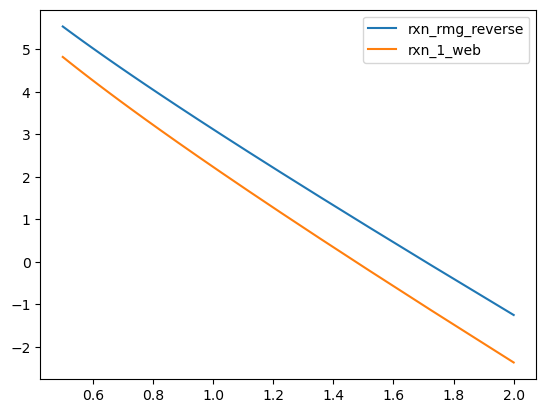

In [10]:
for rxn in rmg_reactions:
    if all(spec in str(rxn) for spec in ['F(19)','H2O(3)', 'HF(4)', 'OH(26)']): 
        display(rxn)
        rxn_of_interest = rxn
        
#reverse the rmg reaction so it faces the same direction as weber
reverse_kinetics = rxn_of_interest.generate_reverse_rate_coefficient()
rxn_RMG_reverse = Reaction(reactants=rxn_of_interest.products, products = rxn_of_interest.reactants)
rxn_RMG_reverse.kinetics = reverse_kinetics
        
        
        
fig = plt.figure()
ax1 = fig.add_subplot(111)

temps = np.linspace(500, 2000, 20)
inverse_temps = [1000/x for x in temps]

web_params = [3.66e+6, 1.9, 9316*1.98]
#units(length='cm', time='s', quantity='mol', act_energy='cal/mol') from weber cti
params = {'A': web_params[0], 'b': web_params[1], 'Ea': web_params[2]}
rxn_1_web = Reaction(kinetics = Arrhenius(A=(params['A'], 'cm^3/(mol*s)'), n=params['b'], Ea=(params['Ea'], 'cal/mol')))   


for rxn, label in zip([rxn_RMG_reverse, rxn_1_web], ['rxn_rmg_reverse', 'rxn_1_web']): 
    ax1.plot(inverse_temps, get_rate_data(rxn), label=label)
plt.legend()

In [7]:
rxn_RMG_reverse.kinetics.A

(242.088,'m^3/(mol*s)')

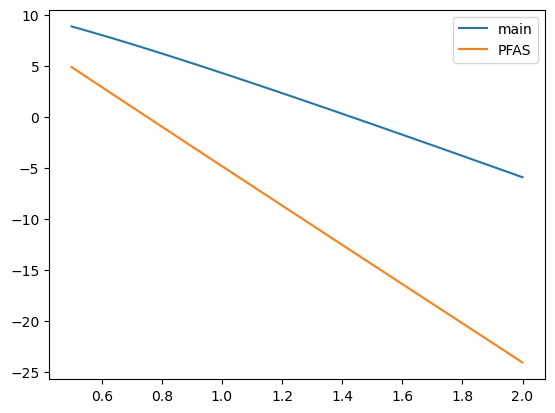

In [6]:
#1,3 sigmatropic rearrangment


fig = plt.figure()
ax1 = fig.add_subplot(111)

main_params = [4.615820e+26, -3.68, 51.867]
#units(length='cm', time='s', quantity='mol', act_energy='cal/mol') from weber cti
params = {'A': main_params[0], 'b': main_params[1], 'Ea': main_params[2]}
main_rxn = Reaction(kinetics = Arrhenius(A=(params['A'], 's^-1'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))   

PFAS_params = [3.389980e+12, 0.571, 87.334]
params = {'A': PFAS_params[0], 'b': PFAS_params[1], 'Ea': PFAS_params[2]}
PFAS_rxn = Reaction(kinetics = Arrhenius(A=(params['A'], 's^-1'), n=params['b'], Ea=(params['Ea'], 'kcal/mol')))   

for rxn, label in zip([main_rxn, PFAS_rxn], ['main', 'PFAS']): 
    ax1.plot(inverse_temps, get_rate_data(rxn), label=label)
plt.legend()

In [7]:
thermolibs = [
    'C1_C2_Fluorine', #putting Siddha's as most trusted because Caroline used this thermo for calcs
    'PFCA_thermo',
    'Fluorine',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'halogens',
    'CHOF_G4',
    'CHOCl_G4',
    'CHOBr_G4',
    'CHOFCl_G4',
    'CHOFBr_G4',
    'CHOFClBr_G4',
    'DFT_QCI_thermo',
    '2-BTP_G4',
    'thermo_DFT_CCSDTF12_BAC',
    'SulfurHaynes'
    ]

families = ['1,3_sigmatropic_rearrangement']
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = thermolibs,  # Can add others if necessary
    kinetics_families = families,
    reaction_libraries = [],
    kinetics_depositories = ['training'],
)

In [18]:
node_of_interest = 'Root_N-1R!H-inRing_N-2R!H->N_N-3R!H->O_N-3CN->N_N-4R!H->Br_N-4CClF->Cl_Ext-2CO-R'
for tr in database.kinetics.families['1,3_sigmatropic_rearrangement'].groups.entries[node_of_interest].item:
    display(tr)

TypeError: 'rmgpy.molecule.group.Group' object is not iterable

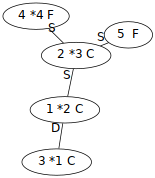

In [19]:
database.kinetics.families['1,3_sigmatropic_rearrangement'].groups.entries[node_of_interest].item

In [21]:
templateRxnMap = database.kinetics.families['1,3_sigmatropic_rearrangement'].get_reaction_matches(thermo_database=database.thermo,remove_degeneracy=True,get_reverse=True,exact_matches_only=False,fix_labels=True)


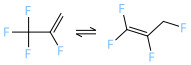

In [26]:
templateRxnMap[node_of_interest][0]

In [25]:
templateRxnMap[node_of_interest][0].kinetics

Arrhenius(A=(1.69499e+12,'s^-1'), n=0.570599, Ea=(365.404,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.09436, dn = +|- 0.0119373, dEa = +|- 0.0624055 kJ/mol""")

In [3]:
thermolibs = [
    'C1_C2_Fluorine', #putting Siddha's as most trusted because Caroline used this thermo for calcs
    'PFCA_thermo',
    'Fluorine',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'halogens',
    'CHOF_G4',
    'CHOCl_G4',
    'CHOBr_G4',
    'CHOFCl_G4',
    'CHOFBr_G4',
    'CHOFClBr_G4',
    'DFT_QCI_thermo',
    '2-BTP_G4',
    'thermo_DFT_CCSDTF12_BAC',
    'SulfurHaynes'
    ]

families = ['R_Recombination']
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = thermolibs,  # Can add others if necessary
    kinetics_families = families,
    reaction_libraries = [],
    kinetics_depositories = ['training'],
)

In [4]:
templateRxnMap = database.kinetics.families['R_Recombination'].get_reaction_matches(thermo_database=database.thermo,remove_degeneracy=True,get_reverse=True,exact_matches_only=False,fix_labels=True)

PF8acid <=> PF7alkyr + rCOOH


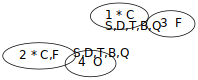

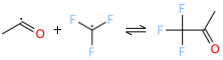

Arrhenius(A=(4e+13,'cm^3/(mol*s)'), n=0, Ea=(0,'cal/mol'), T0=(1,'K'))
PF8acid <=> PF4alkyr + rPF4acid


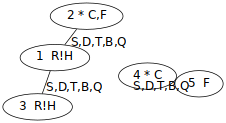

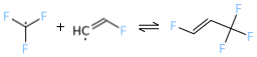

Arrhenius(A=(0.0678417,'m^3/(mol*s)'), n=2.13578, Ea=(0.502021,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.33218, dn = +|- 0.0379709, dEa = +|- 0.198504 kJ/mol""")
PF8acid <=> PF5alkyr + rPF3acid


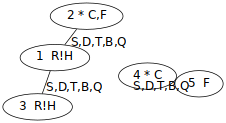

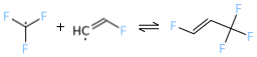

Arrhenius(A=(0.0678417,'m^3/(mol*s)'), n=2.13578, Ea=(0.502021,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.33218, dn = +|- 0.0379709, dEa = +|- 0.198504 kJ/mol""")
PF8acid <=> PF3alkyr + rPF5acid


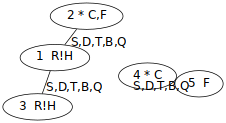

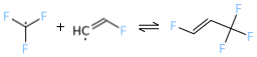

Arrhenius(A=(0.0678417,'m^3/(mol*s)'), n=2.13578, Ea=(0.502021,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.33218, dn = +|- 0.0379709, dEa = +|- 0.198504 kJ/mol""")


In [8]:
nodes = [
    'Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_4R!H->O', #CHO2(300) + C7F15(301) <=> PFOA(1), PF7alkylr
    'Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_Ext-4R!H-R', #'F[C](F)C(F)(F)C(F)(F)C(F)(F)F(291) + O=C(O)C(F)(F)C(F)(F)[C](F)F(290) <=> PFOA(1)': ['PF8acid <=> PF4alkyr + rPF4acid', '--d', 'steelblue'],
    'Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_Ext-4R!H-R', #'C3HF4O2(292) + C5F11(293) <=> PFOA(1)', 'PF8acid <=> PF5alkyr + rPF3acid'
    'Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_Ext-4R!H-R', #'PF8acid <=> PF3alkyr + rPF5acid', 'C3F7(295) + C5HF8O2(294) <=> PFOA(1)', 
]
    
reaction_label = [    'PF8acid <=> PF7alkyr + rCOOH',
'PF8acid <=> PF4alkyr + rPF4acid',
'PF8acid <=> PF5alkyr + rPF3acid',
'PF8acid <=> PF3alkyr + rPF5acid']
    
for rl, node_of_interest in zip(reaction_label, nodes):
    print(rl)
    display(database.kinetics.families['R_Recombination'].groups.entries[node_of_interest].item)
    
    for tr in templateRxnMap[node_of_interest]:
        display(tr)
        print(tr.kinetics)

In [4]:
thermolibs = [
    'C1_C2_Fluorine', #putting Siddha's as most trusted because Caroline used this thermo for calcs
    'PFCA_thermo',
    'Fluorine',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'halogens',
    'CHOF_G4',
    'CHOCl_G4',
    'CHOBr_G4',
    'CHOFCl_G4',
    'CHOFBr_G4',
    'CHOFClBr_G4',
    'DFT_QCI_thermo',
    '2-BTP_G4',
    'thermo_DFT_CCSDTF12_BAC',
    'SulfurHaynes'
    ]

families = ['R_Recombination']
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = thermolibs,  # Can add others if necessary
    kinetics_families = families,
    reaction_libraries = [],
    kinetics_depositories = ['training'],
)

In [5]:
FCO_molecule=Molecule(smiles='O=[C]F')
C6F13_molecule=Molecule(smiles='F[C](F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F')
PFHpO_molecule=Molecule(smiles='O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F')

FCO_species = Species(molecule=[FCO_molecule])
C6F13_species = Species(molecule=[C6F13_molecule])
PFHpO_species = Species(molecule=[PFHpO_molecule])

reactants_ = [FCO_species, C6F13_species]
products_ = [PFHpO_species]

for spec in reactants_+products_:
    spec.thermo = database.thermo.get_thermo_data(spec)
    
    
reaction=Reaction(reactants=[FCO_species, C6F13_species], products=[PFHpO_species])

database.kinetics.families['R_Recombination'].add_atom_labels_for_reaction(reaction)
template_labels = database.kinetics.families['R_Recombination'].get_reaction_template_labels(reaction)
template = database.kinetics.families['R_Recombination'].retrieve_template(template_labels)
node = template[0].label

kinetics = database.kinetics.families['R_Recombination'].get_kinetics_for_template(template, degeneracy=reaction.degeneracy)[0]

In [11]:
C6F13_species.get_enthalpy(298) #returns in J/mol

print(C6F13_species.get_enthalpy(298)/4184) #ok the database also has the correct kcal/mol

-604.6303324708027


In [13]:
C6F13_species.thermo

NASA(polynomials=[NASAPolynomial(coeffs=[22.9303,0.0485491,-2.72171e-05,5.34399e-09,-3.67827e-13,-313021,-67.8166], Tmin=(100,'K'), Tmax=(849.23,'K')), NASAPolynomial(coeffs=[-5.08115,0.222802,-0.000409742,3.64308e-07,-1.23314e-10,-309789,53.761], Tmin=(849.23,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(436.51,'J/(mol*K)'), label="""C5F11CF2""", comment="""Thermo library: PFCA_thermo""")

In [23]:
C6F13_species.get_thermo_data().E0?

Object `E0` not found.


In [19]:
print(C6F13_species.get_thermo_data().E0)

None


In [14]:
C6F13_species.get_thermo_data().E0.value_si #if spec.get_thermo_data().E0 is not None else spec.get_thermo_data().to_wilhoit().E0.value_si

AttributeError: 'NoneType' object has no attribute 'value_si'

ValueError: No valid NASA polynomial at temperature 0 K.

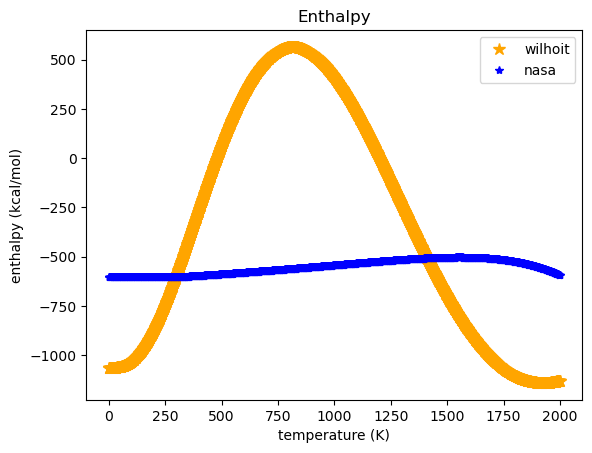

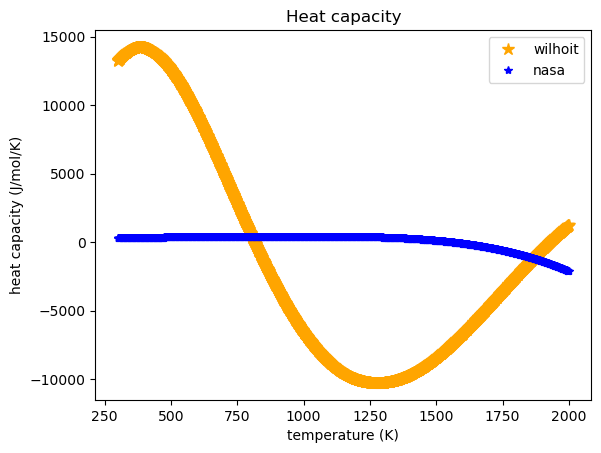

In [54]:
#compare thermo values of NASA polynomial versus wilhoit

wilhoit = C6F13_species.get_thermo_data().to_wilhoit()
nasa = C6F13_species.get_thermo_data()



fig = plt.figure()
ax1 = fig.add_subplot(111)

w_enthalpies=[]
n_enthalpies=[]
for temp in range(1,2000): 
    w_enthalpy = wilhoit.get_enthalpy(temp) #in J/mol
    n_enthalpy = nasa.get_enthalpy(max(300,temp))
    w_enthalpies.append(w_enthalpy/4184)
    n_enthalpies.append(n_enthalpy/4184)
    
ax1.plot(range(1,2000), w_enthalpies, '*', markersize=9, c='orange', label='wilhoit') #in kcal/mol
ax1.plot(range(1,2000), n_enthalpies, '*', c='blue', label='nasa') #in kcal/mol


plt.xlabel('temperature (K)')
plt.ylabel('enthalpy (kcal/mol)')
plt.title('Enthalpy')
plt.legend()



# for temp in np.arange(0.001,1,0.1): 
#     w_enthalpy = wilhoit.get_enthalpy(temp) #in J/mol
#     n_enthalpy = nasa.get_enthalpy(temp)
    
    
#     ax1.plot(temp, w_enthalpy/4184, '*', markersize=9, c='orange') #in kcal/mol
#     ax1.plot(temp, n_enthalpy/4184, '*', c='blue') #in kcal/mol


# plt.xlabel('temperature (K)')
# plt.ylabel('enthalpy (kcal/mol)')
# plt.title('Enthalpy')

fig = plt.figure()
ax1 = fig.add_subplot(111)


w_hcs=[]
n_hcs=[]
#compare heat capacity values
for temp in range(300,2000): 
    w_hc = wilhoit.get_heat_capacity(temp) #in J/mol*K 
    n_hc = nasa.get_heat_capacity(temp)
    w_hcs.append(w_hc)
    n_hcs.append(n_hc)
    
ax1.plot(range(300,2000), w_hcs, '*', markersize=9, c='orange', label='wilhoit') #in kcal/mol
ax1.plot(range(300,2000), n_hcs, '*', c='blue', label='nasa') #in kcal/mol


plt.xlabel('temperature (K)')
plt.ylabel('heat capacity (J/mol/K)')
plt.title('Heat capacity')
plt.legend()

print(wilhoit.get_heat_capacity(0.001), nasa.get_heat_capacity(0))


In [57]:
nasa

NASA(polynomials=[NASAPolynomial(coeffs=[22.9303,0.0485491,-2.72171e-05,5.34399e-09,-3.67827e-13,-313021,-67.8166], Tmin=(100,'K'), Tmax=(849.23,'K')), NASAPolynomial(coeffs=[-5.08115,0.222802,-0.000409742,3.64308e-07,-1.23314e-10,-309789,53.761], Tmin=(849.23,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(436.51,'J/(mol*K)'), label="""C5F11CF2""", comment="""Thermo library: PFCA_thermo""")

In [18]:
#apply thermo to the reaction
reaction.get_enthalpy_of_reaction(298) * 0.000239006 #convert from J/mol to kcal/mol

-89.00182323016168

In [22]:
kinetics #kinetics at node

ArrheniusBM(A=(2.63131e-11,'m^3/(mol*s)'), n=4.71246, w0=(173,'kJ/mol'), E0=(139.101,'kJ/mol'), Tmin=(300,'K'), Tmax=(2000,'K'), uncertainty=RateUncertainty(mu=0.0, var=33.13686319048999, Tref=1000.0, N=1, data_mean=0.0, correlation='Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_Ext-4R!H-R',), comment="""Estimated from node Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_Ext-4R!H-R in family R_Recombination.""")

In [19]:
kinetics.to_arrhenius(dHrxn=reaction.get_enthalpy_of_reaction(298))

Arrhenius(A=(2.63131e-11,'m^3/(mol*s)'), n=4.71246, Ea=(0,'kJ/mol'), T0=(1,'K'), Tmin=(300,'K'), Tmax=(2000,'K'), uncertainty=RateUncertainty(mu=0.0, var=33.13686319048999, Tref=1000.0, N=1, data_mean=0.0, correlation='Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_Ext-4R!H-R',), comment="""Estimated from node Root_N-1R->H_N-1BrCClFINOPSSi->N_N-1BrCClFOS->Cl_N-1BrCFOS->O_N-1BrCFS-inRing_1BrCFS->C_N-2R->S_N-2BrCF->Br_Ext-1C-R_3R!H->F_Ext-2CF-R_Ext-4R!H-R in family R_Recombination.""")

In [20]:
templateRxnMap = database.kinetics.families['R_Recombination'].get_reaction_matches(thermo_database=database.thermo,remove_degeneracy=True,get_reverse=True,exact_matches_only=False,fix_labels=True)

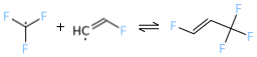

In [21]:
for rxn in templateRxnMap[node]:
    display(rxn)

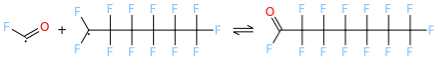

In [23]:
reaction

In [26]:
# -3132414.5071161315
# -187894.33068865057
#-4453014.693115236

-3132414.5071161315 - (-187894.33068865057+-4453014.693115236)

1508494.5166877555

In [12]:
for spec, num in zip(['PFHpO', 'FCO', 'C6F13'], [-3132414.5071161315 , -187894.33068865057, -4453014.693115236]):
    print(spec, num*0.000239006, num/4184)#value in kcal/mol

    
    #C6F13 is has different thermo associated. 
    #coming from PFCA_thermo, GA says it should be ΔH∘f(298 K) =−604.83 kcal/mol
    #phil (corrected thermo) says its –595.70 kcal/mol

PFHpO -748.6658616877982 -748.6650351615993
FCO -44.90787240057162 -44.90782282233522
C6F13 -1064.2972297427002 -1064.2960547598557
